In [1]:
## FINESSE PACKAGE IMPORTS ##
import finesse
from finesse.components import Laser, Lens, Mirror, Nothing, Space, Cavity

## INTERNAL PACKAGES ##
from PIL import Image
from pathlib import Path
from pprint import pprint
from itertools import zip_longest
from functools import reduce
    
## EXTERNAL PACKAGES ##
import matplotlib.pyplot as plt
import numpy as np

## USER PACAKGES ##
# setup_finesse.py IS WHERE I DEFINE ALL THE IMPORTANT FUNCTIONS
from setup_finesse import calculate_nr, setup_simple, setup_cavity_with_crystal, get_relevant_qs, setup_focusing, get_focusing_qs

# How The Cavity Has Been Modelled

A Laser Node is placed $\frac{L_{\text{cavity}}}{2} - \frac{L_\text{crys}}{2}$ away from the left-most edge of the crystal, represented by a Nothing node.
This node is placed $\frac{L_\text{crys}}{2}$ away from a Nothing node representing the crystal centre.
This centre is placed $\frac{L_\text{crys}}{2}$ away from another Nothing node that represents the right-most edge of the crystal.
Finally, the right-most edge of the crystal is placed $\frac{L_{\text{cavity}}}{2} - \frac{L_\text{crys}}{2}$ away a Lens node representing a curved mirror.

It may seem strange that I've arranged the Laser this far away, but it was programmatically simplest this way.
From `setup_finesse.py`, in the `setup_cavity_with_crystal` function, you can see this in action.
A "unit component", like a unit cell in a crystal, is a set of `OpticalNodes` which can be created in a `for` loop, to simulate light bouncing around a cavity.

I've explained this because whenever you create a beam parameter `q=finesse.gaussian.BeamParam()`, you need to specify the length of the cavity so that you can correctly place the beam waist in the model in the `z` parameter.
Moreover, this z parameter needs to be negative, so that the code understands that we're focusing the light into the crystal.
I've written a helper function below, `get_z_for_q()` to help with this.

In [10]:
def get_z_for_q(L):
    # L = cavity length in m
    return -((L/2) + 10e-3)

In [ ]:
def plot_everything(qs_for_each_L, Ls, figsize=(8,8)):
    """Creates a 3 column figure, plotting data for the crystal edge, left mirror and right mirror's beam waists
    """
    maximum_waist = 0.25 # axes will be in mm already.

    # gets crystal edge ws and zs
    crys_ws = [[q.w for q in qs["crystals"]["qs"]] for qs in qs_for_each_L]
    crys_zs = [[z for z in qs["crystals"]["zs"]] for qs in qs_for_each_L]

    #print("WS")
    #pprint(crys_ws)
    #print("ZS")
    #pprint(crys_zs)

    # gets left mirror ws and zs
    left_mirror_ws = [[q.w for q in qs["mirrors"]["left"]["qs"]] for qs in qs_for_each_L]
    left_mirror_zs = [[z for z in qs["mirrors"]["left"]["zs"]] for qs in qs_for_each_L]

    # gets right mirror ws and zs
    right_mirror_ws = [[q.w for q in qs["mirrors"]["right"]["qs"]] for qs in qs_for_each_L]
    right_mirror_zs = [[z for z in qs["mirrors"]["right"]["zs"]] for qs in qs_for_each_L]

    fig = plt.figure(layout="constrained", figsize=figsize)
    fig.suptitle("Radii of the Beam at the Crystal's edges (red) and at the left and right mirrors (blue)")
    fig.supxlabel("Distance Propagated, "+r"$z$,"+" [m]")
    fig.supylabel("Beam Radius, "+r"$\omega$,"+" [mm]")
    
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=len(Ls), ncols=1)

    # edge case where you only use one cavity length
    if len(Ls) == 1:
         # create 1x3 subplots per subfig
        ax = subfigs.subplots(nrows=1, ncols=3)

        ax[2].set_yticks([])

        ax[0].plot(crys_zs[0], 1000*np.array(crys_ws[0]), color="tab:red", label=Ls[0])
        ax[1].plot(left_mirror_zs[0], 1000*np.array(right_mirror_ws[0]), color="tab:blue", label=Ls[0])
        ax[2].plot(right_mirror_zs[0], 1000*np.array(right_mirror_ws[0]), color="tab:blue", label=Ls[0])
    
        ax[0].hlines(maximum_waist, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color="black", linestyle="dashed")
        return
        
    for L, subfig in enumerate(subfigs):
        subfig.suptitle(r"$L=$"+str(Ls[L])+"m")
    
        # create 1x3 subplots per subfig
        ax = subfig.subplots(nrows=1, ncols=3)

        ax[2].set_yticks([])

        ax[0].plot(crys_zs[L], 1000*np.array(crys_ws[L]), color="tab:red", label=L)
        ax[1].plot(left_mirror_zs[L], 1000*np.array(right_mirror_ws[L]), color="tab:blue", label=L)
        ax[2].plot(right_mirror_zs[L], 1000*np.array(right_mirror_ws[L]), color="tab:blue", label=L)
    
        ax[0].hlines(maximum_waist, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color="black", linestyle="dashed")


# Upper Bound for $\omega_0$

When the light bounces inside the cavity with a crystal inside of it, the spot size or beam radius should not exceed the cross-sectional area of the phase-matching channel ($A=0.5\times 0.5$mm).
If it does, the light will also travel through glass cover instead of the crystal; the finesse of the cavity will be compromised.
The beam radius changes with a function of propagation distance according to:

$$\omega(z) = \omega_0 \sqrt{1 + \frac{z}{z_R}^2} \quad (1)$$

Our condition is $\omega(z_R) < 0.25$mm.
Plugging this into Eqn (1):
$\omega_0 < \frac{\sqrt{2}}{8}$mm

We can model our cavity as a series of lenses with $f=0.5$m, seperated by free-space and repeatitions of a crystal.

**Assumption: The beam has already been focused down such that, at a distance of $\frac{L}{2}$ away from the first mirror (ie. at the centre of the crystal), $\omega_0 = \frac{\sqrt{2}}{8}$mm.**

*Question: What does the beam's radius look like at the centre of the crystal and at each mirror's face as it propagates through the cavity?*
*What would it look like for different cavity lengths?*

# $\omega_0=\frac{\sqrt{2}}{8} \approx 0.177$mm

In [2]:
W_UPPER_BOUND = (2**0.5)*(1e-3)/8
q_i = finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_UPPER_BOUND,z=-10e-3)
print(q_i)

BeamParam(w0=176.78 um, z=-10 mm, w=178.97 um, Rc=-411.18 mm)


## Cavities Lengths in Steps of 0.25m

[<BeamParam (w0=176.78 um, w=416.19 um, z=-135 mm, nr=1, λ=1.55 um) at 0x7f28ea71fc50>,
 <BeamParam (w0=176.78 um, w=746.88 um, z=-260 mm, nr=1, λ=1.55 um) at 0x7f28ea71fb60>,
 <BeamParam (w0=176.78 um, w=1.4343 mm, z=-510 mm, nr=1, λ=1.55 um) at 0x7f28ea5e4ad0>,
 <BeamParam (w0=176.78 um, w=2.1285 mm, z=-760 mm, nr=1, λ=1.55 um) at 0x7f29441268a0>,
 <BeamParam (w0=176.78 um, w=2.8244 mm, z=-1.01 m, nr=1, λ=1.55 um) at 0x7f28e7be6690>]
0.115 m
0.24 m
0.49 m
0.74 m
0.99 m


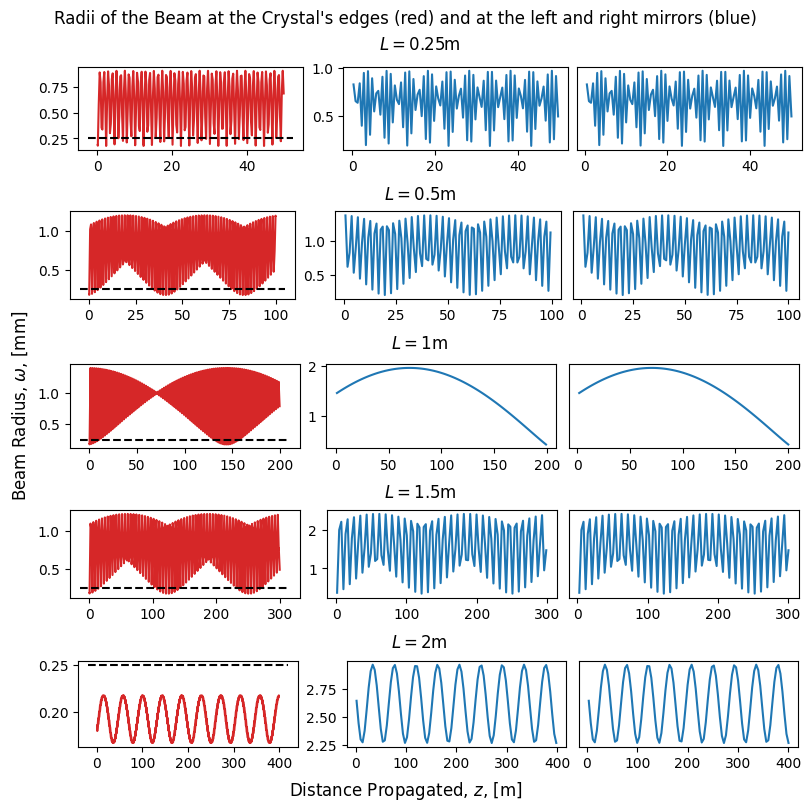

In [13]:
Ls_big = [0.25, 0.5, 1, 1.5, 2]
q_inits = [finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_UPPER_BOUND,z=get_z_for_q(L)) for L in Ls_big]
pprint(q_inits)

qs_big = [get_relevant_qs(200, L, q) for L,q in zip(Ls_big, q_inits)]
plot_everything(qs_big, Ls_big)

plt.show()

### Conclusion

Clearly, the spotsize outgrew our upper limit (dashed line).
Smaller cavities yielded more consistent spot sizes for each reflection.
This is worth exploring, with the same $q_i$.

## Cavities Lengths in Steps of 0.01m Below 0.25m

0.04 m
0.049999999999999996 m
0.055 m
0.060000000000000005 m
0.065 m
0.07 m
0.07500000000000001 m
0.08 m
0.085 m
0.09000000000000001 m


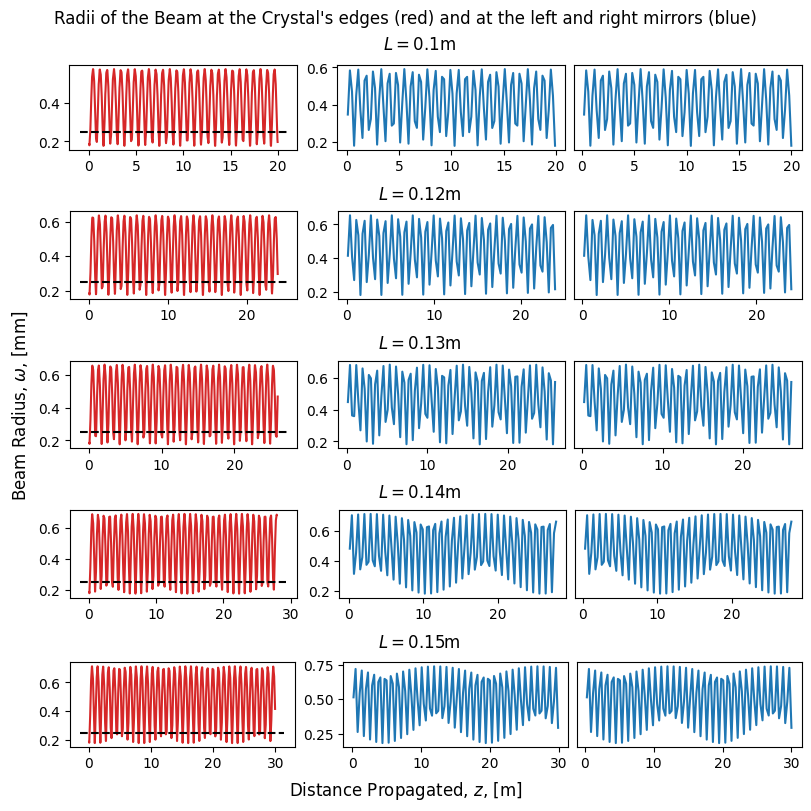

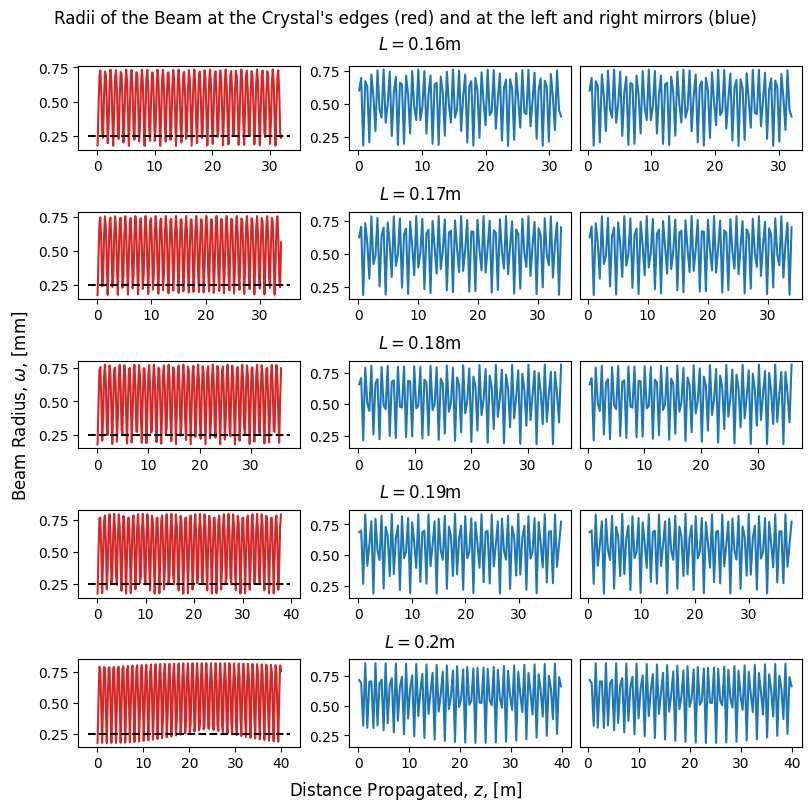

In [14]:
Ls_10_15 = [0.1, 0.12, 0.13, 0.14, 0.15]
q_inits = [finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_UPPER_BOUND,z=get_z_for_q(L)) for L in Ls_10_15]
qs_10_15 = [get_relevant_qs(200, L, q) for L,q in zip(Ls_10_15, q_inits)]
plot_everything(qs_10_15, Ls_10_15)

Ls_16_20 = [0.16, 0.17, 0.18, 0.19, 0.2]
qs_16_20 = [get_relevant_qs(200, L, q) for L,q in zip(Ls_16_20, q_inits)]
plot_everything(qs_16_20, Ls_16_20)
plt.show()

### Conclusion

As the length of the cavity increased, on average the spot size drifted away from the target upper bound spot size (dashed line).
There seems to be some noticable periodicity at 0.2m and 0.19m.

# Changing the Rayleigh range

Instead of fixing the beam waist in the centre of the crystal, instead I will change the Rayleigh Length to investigate at which point these mirrors become feasable

[<BeamParam (w0=99.336 um, w=314.13 um, z=-60 mm, nr=1, λ=1.55 um) at 0x7f28e61593d0>,
 <BeamParam (w0=99.336 um, w=433.71 um, z=-85 mm, nr=1, λ=1.55 um) at 0x7f28e5066ba0>,
 <BeamParam (w0=99.336 um, w=555.3 um, z=-110 mm, nr=1, λ=1.55 um) at 0x7f28e50a4da0>,
 <BeamParam (w0=99.336 um, w=677.84 um, z=-135 mm, nr=1, λ=1.55 um) at 0x7f28e50a7c50>]
0.04 m
0.065 m
0.09000000000000001 m
0.115 m


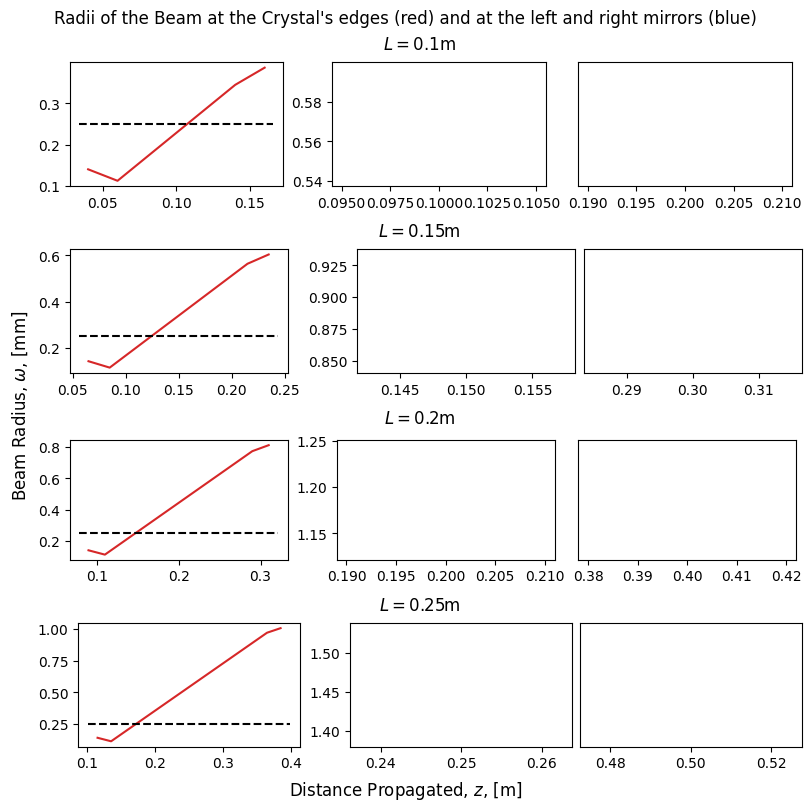

In [27]:
Ls_10_25 = [0.1, 0.15, 0.2, 0.25]
RAYLEIGH_LENGTH = 20e-3 # <---------------- PLAY WITH THIS!

q_inits = [finesse.gaussian.BeamParam(wavelength=1550e-9, zr=RAYLEIGH_LENGTH, z=get_z_for_q(L)) for L in Ls_10_25]
pprint(q_inits)
qs_10_25 = [get_relevant_qs(2, L, q) for L,q in zip(Ls_10_25, q_inits)]
plot_everything(qs_10_25, Ls_10_25)
plt.show()

### Conclusion

That looks *much* better!
The beam is completely contained inside the crystal as it travels through it, with some wiggle room to spare!
As we go towards a 0.25m cavity, we have less wiggle room to work with.
Something to keep in mind.

# Using the Optimal Focused Waist for SHG

What if we used the same beam parameters that we have currently downstairs on the bench?
[According to Boyd and Kleinmann's paper](https://pubs.aip.org/aip/jap/article/39/8/3597/5204/Parametric-Interaction-of-Focused-Gaussian-Light) the rayleigh length, $z_R$, is found from a calculated ratio, $\xi=2.84$, which they experimentally verified:
$$z_R = \frac{L_{\text{crys}}}{2 \times 2.84}$$
$$ \omega_0 = \sqrt{\frac{L_\text{crys}\lambda}{2\pi \times 2.84}} \quad (2)$$

If we were to use 775nm for our process, $\omega_0 \approx 30\mu m$.

In [27]:
W_OPTIMAL = 30e-6
q_focu = finesse.gaussian.BeamParam(wavelength=1550e-9, zr=80e-3, z=-10e-3)
print(q_focu)

BeamParam(w0=198.67 um, z=-10 mm, w=200.22 um, Rc=-650 mm)


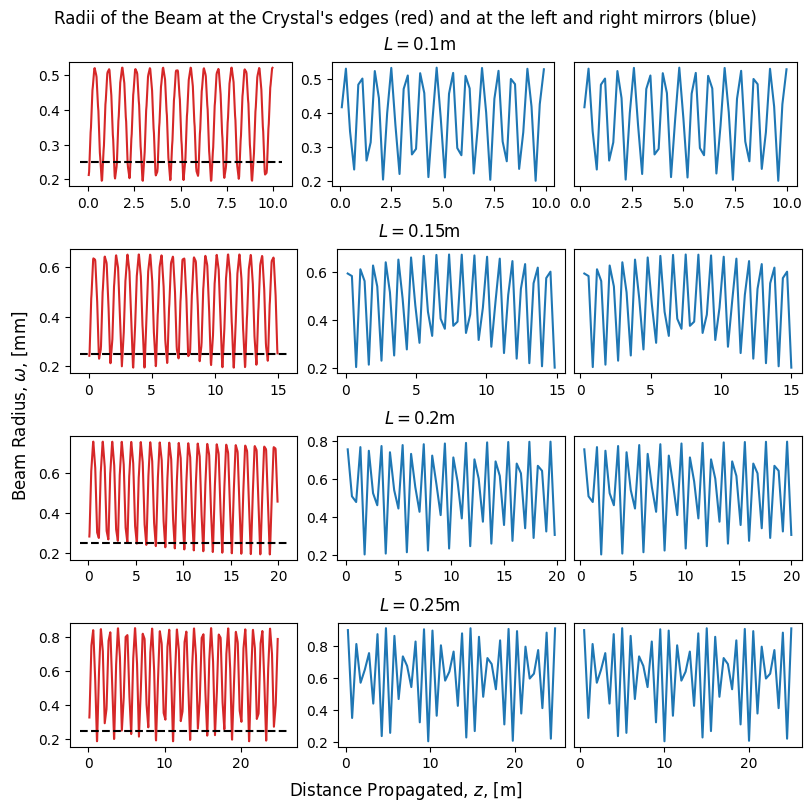

In [28]:
Ls_10_25 = [0.1, 0.15, 0.2, 0.25]
qs_10_25 = [get_relevant_qs(100, L, q_focu) for L in Ls_10_25]

plot_everything(qs_10_25, Ls_10_25)
plt.show()

## Conclusion

The optimal focusing is therefore not feasable with the crystal that we have.
On the optical bench, however, we already compromised on this optimal rayleigh length to get a more feasibly beam waist.
We matched half the crystal's length, 10mm, to the Rayleigh length.
$$ \omega_0 = \sqrt{\frac{\lambda Z_R}{\pi}} \approx 50\mu m, \quad\quad Z_R=10mm$$
Using this beam waist, the results are similar to those above.
This demonstrates that the current setup is not sufficient; It is not a simple case of plonking mirrors around the crystal with this lens configuration.
The current beam waist of $\approx 50\mu m$ yields similar results and has to be compromised.



## Finding the Best Compromise for Beam Waist

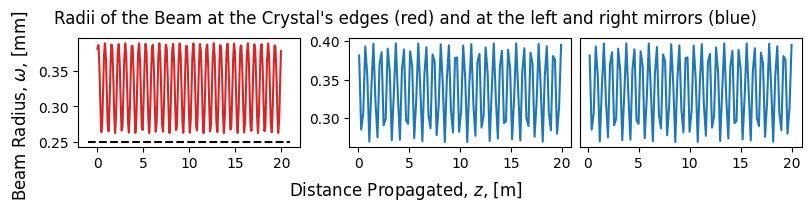

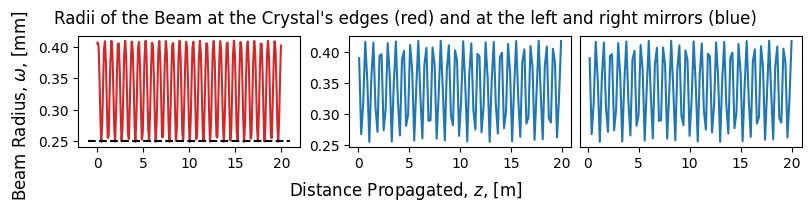

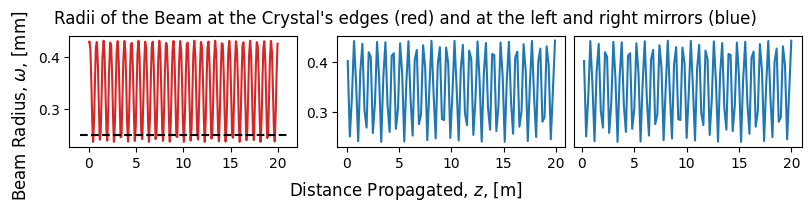

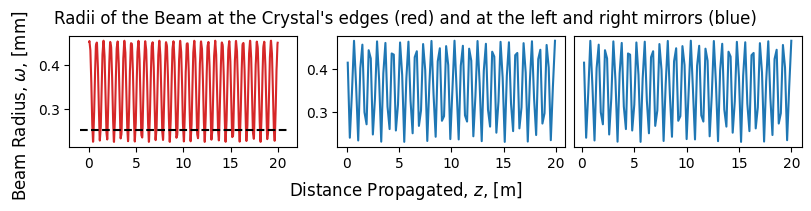

In [94]:
possible_ws = [375e-6, 400e-6, 425e-6, 450e-6,]
start_qs = [finesse.gaussian.BeamParam(wavelength=1550e-9, w0=possible_w,z=10e-3) for possible_w in possible_ws]

L = 0.1
results = [get_relevant_qs(200, L, q) for q in start_qs]

for res in results: plot_everything([res], [L], figsize=(8,2))

## Conclusion: $\omega_0 > 315\mu m$ 

The beam needs to be focused into the cavity with a waist greater than $315 \mu m$.
In needs to be experimentally confirmed that a beam waist that is 6 times larger than what we currently have will still yield an appreciable efficiency and therefore count rate.
If this is not the case, all is not lost, as the Waveguide can be pumped with more optical power using the BOOSTIK linecard amplifier.

# Finding Setup Required to Focus Beam to $\omega = 315\mu m$

The beam-waist starts at the collimator with $\omega_0 = 2.27mm$.
Using two lenses, how can we focus the beam down to reach $315 \mu m$?
My strategy is to work backwards from the crystal-cavity to reach this target.